# Additional libraries


In [1]:
# Additional libraries for Colab
!pip install pytreebank
!pip install transformers
!pip install torchmetrics

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=dd678d9498ca5a6f11f5f0126e4d3789f6a7f4d10ded9250c92811ab02022763
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank
     |████████████████████████████████| 2.5MB 12.4MB/s 
     |████████████████████████████████| 901kB 35.4MB/s 
     |████████████████████████████████| 3.3MB 35.6MB/s 
     |████████████████████████████████| 235kB 11.1MB/s 


# Models

Load different pretrained models and then modify the configuration of the tokenizer to manage padding tokens.

In [8]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

#Standard model
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=5)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# default to right padding
tokenizer.padding_side = "right"

# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

#Distilled model
model = GPT2ForSequenceClassification.from_pretrained("distilgpt2", num_labels=5)
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

# default to right padding
tokenizer.padding_side = "right"

# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
from transformers import GPT2Tokenizer, AutoModelForSequenceClassification

#already fine-tuned model saved in my Huggingface repository
model = AutoModelForSequenceClassification.from_pretrained("MiBo/SAGPT2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# default to right padding
tokenizer.padding_side = "right"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

Model structure and number of parameters

In [9]:
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

# Import dataset Yelp-5

Yelp-5 is provided in a file with a list of JSON, so we need to read it 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import json

#Set the file path, I used my Google Drive 
filepath = '/content/drive/MyDrive/yelp.json'

reviews = []
print("Started Reading JSON file which contains multiple JSON document")
with open(filepath) as f:
    for jsonObj in f:
        reviewsDict = json.loads(jsonObj)
        reviews.append(reviewsDict)
print('Finished!')

Started Reading JSON file which contains multiple JSON document
Finished!


Extend the basic Dataset Pytorch class 

In [11]:
import torch

class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

After the extraction of the first 100000 reviews,
create a training set and a validation test with preprocessed sequences

These reviews can be very long, so I truncated the sequnece to 128 

## Preprocessing
For each sequence:
- Convert labels in SST-5 range (0 to4)
- Tokenization
- Add special tokens such as [eos]
- pad the sequence until we reach the size of the longest sequence.
- These reviews can be very long, so I truncated the sequnece to 128 
- Creation of the Attention mask (vector that indicates which tokens belong to the sentence and which are just padding)

In [12]:

X_train_yelp = []
y_train_yelp = []

for r in reviews[:90000]:
  x = r['text']
  # Convert labels from 1-5 to 0-4
  y = int(r['stars']) - 1
  X_train_yelp.append(x)
  y_train_yelp.append(y)

X_train_encodings_yelp = tokenizer(
            X_train_yelp,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            max_length = 128,
            truncation=True
        )
train_dataset_yelp = YelpDataset(X_train_encodings_yelp, y_train_yelp)

X_val_yelp = []
y_val_yelp = []

for r in reviews[90000:100000]:
  x = r['text']
  # Convert labels from 1-5 to 0-4
  y = int( r['stars']) - 1
  X_val_yelp.append(x)
  y_val_yelp.append(y)
  
X_val_encodings_yelp = tokenizer(
            X_val_yelp,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=True,
            max_length = 128,
            truncation=True
        )
val_dataset_yelp = YelpDataset(X_val_encodings_yelp, y_val_yelp)

# Training with Yelp-5

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch.utils.data import DataLoader
from transformers import  AdamW
import torchmetrics

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 1

# Creation of Pytorch DataLoaders with shuffle=True for the training phase
train_dataloader = DataLoader(train_dataset_yelp, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset_yelp, batch_size=32, shuffle=True)

#Adam algorithm optimized for tranformers architectures
optimizer = AdamW(model.parameters(), lr=1e-5)

# Setup for training with gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # initialize metric
    metric = torchmetrics.Accuracy()

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode: Dropout layers are active
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Compute time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader. 
        #
        #  copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # clear any previously calculated gradients before performing a
        # backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Perform a backward pass to compute the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This helps and prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()


    # Compute the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure performance on
    # the validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode: the dropout layers behave differently
    model.eval()

    total_val_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for training.
        with torch.no_grad():        

            # Forward pass, calculate logits
            # argmax(logits) = argmax(Softmax(logits))
            outputs = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_val_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Compute the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        val_accuracy = metric(logits.softmax(dim=1), label_ids)
        

    # Report the final accuracy for this validation phase.
    # metric on all batches using custom accumulation from torchmetrics library
    val_accuracy = metric.compute()
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))

    # Compute the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Import dataset SST-5

In [ ]:
import pytreebank
# load the sentiment treebank corpus in the parenthesis format,
# e.g. "(4 (2 very ) (3 good))"
dataset = pytreebank.load_sst()
# add Javascript and CSS to the Ipython notebook
pytreebank.LabeledTree.inject_visualization_javascript()
# select and example to visualize
example = dataset["train"][3]
# display it in the page
example.display()
print("Text format:")
print(example)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text format:
(2 (2 (2 You) (2 (2 'd) (2 (2 think) (2 (2 by) (2 now) ))))(2 (2 America) (2 (2 (2 would) (1 (2 have) (2 (2 (2 had) (1 (2 enough) (2 (2 of) (2 (2 plucky) (2 (2 British) (1 eccentrics) )))))(4 (2 with) (4 (3 hearts) (3 (2 of) (3 gold) ))))))(2 .) )))


#SST-5 Dataset processing

Now we define functions to extract sequences from the treebank.
There are two versions:
- Extract sequences and labels for each node of the tree
- Extract sequence and label of the root node (entire sentence)

In [ ]:
def tree_to_sequences_and_labels(tree):
  X = []
  y = []
  for s in tree.to_labeled_lines():
    X.append(s[1])
    y.append(s[0]) 
  return X, y

def tree_to_sequences_and_labels_only_root(tree):
  X = []
  y = []
  # only the first node
  for s in tree.to_labeled_lines()[:1]:
    X.append(s[1])
    y.append(s[0]) 
  return X, y

Extend the basic Dataset Pytorch class  

In [ ]:
import torch

class SST5Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Preprocessing
For each sequence:
- Tokenization
- Add special tokens such as [eos]
- pad the sequence until we reach the size of the longest sequence (about 60 in SST-5)
- Creation of the Attention mask (vector that indicates which tokens belong to the sentence and which are just padding)

In [ ]:
X_train = []
y_train = []

for t in dataset["train"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_train += x
  y_train += y
X_train_encodings = tokenizer(
            X_train,
            add_special_tokens=True,
            return_attention_mask=False,
            padding=True,
            truncation=True
        )
train_dataset = SST5Dataset(X_train_encodings, y_train)


X_val = []
y_val = []

for t in dataset["dev"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_val += x
  y_val += y
X_val_encodings = tokenizer(
            X_val,
            add_special_tokens=True,
            return_attention_mask=False,
            padding=True,
            truncation=True
        )
val_dataset = SST5Dataset(X_val_encodings, y_val)


X_test = []
y_test = []

for t in dataset["test"]:
  x, y =  tree_to_sequences_and_labels(t)
  X_test += x
  y_test += y
X_test_encodings = tokenizer(
            X_test,
            add_special_tokens=True,
            return_attention_mask=False,
            padding=True,
            truncation=True
        )
test_dataset = SST5Dataset(X_test_encodings, y_test)

#Training with SST-5

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch.utils.data import DataLoader
from transformers import  AdamW
import torchmetrics 

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 1

# Creation of Pytorch DataLoaders with shuffle=True for the training phase
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

#Adam algorithm optimized for tranformer architectures
optimizer = AdamW(model.parameters(), lr=1e-5)

# Setup for training with gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # initialize metric
    metric = torchmetrics.Accuracy()

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode: Dropout layers are active
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Compute time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from the dataloader. 
        #
        #  copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        # clear any previously calculated gradients before performing a
        # backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = outputs[0]
        logits = outputs[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_train_loss += loss.item()

        # Perform a backward pass to compute the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This helps and prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()


    # Compute the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure performance on
    # the validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode: the dropout layers behave differently
    model.eval()

    total_val_loss = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # copy each tensor to the GPU using the 'to()' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for training.
        with torch.no_grad():        

            # Forward pass, calculate logits
            # argmax(logits) = argmax(Softmax(logits))
            outputs = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = outputs[0]
            logits = outputs[1]
            
        # Accumulate the validation loss.
        total_val_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        label_ids = b_labels.to('cpu')

        # Compute the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        val_accuracy = metric(logits.softmax(dim=1), label_ids)
        

    # Report the final accuracy for this validation phase.
    # metric on all batches using custom accumulation from torchmetrics library
    val_accuracy = metric.compute()
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))

    # Compute the average loss over all of the batches.
    avg_val_loss = total_val_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 1 ========
Training...
  Batch    40  of  4,978.    Elapsed: 0:00:16.
  Batch    80  of  4,978.    Elapsed: 0:00:32.
  Batch   120  of  4,978.    Elapsed: 0:00:47.
  Batch   160  of  4,978.    Elapsed: 0:01:02.
  Batch   200  of  4,978.    Elapsed: 0:01:17.
  Batch   240  of  4,978.    Elapsed: 0:01:32.
  Batch   280  of  4,978.    Elapsed: 0:01:48.
  Batch   320  of  4,978.    Elapsed: 0:02:03.
  Batch   360  of  4,978.    Elapsed: 0:02:18.
  Batch   400  of  4,978.    Elapsed: 0:02:33.
  Batch   440  of  4,978.    Elapsed: 0:02:48.
  Batch   480  of  4,978.    Elapsed: 0:03:04.
  Batch   520  of  4,978.    Elapsed: 0:03:19.
  Batch   560  of  4,978.    Elapsed: 0:03:34.
  Batch   600  of  4,978.    Elapsed: 0:03:49.
  Batch   640  of  4,978.    Elapsed: 0:04:04.
  Batch   680  of  4,978.    Elapsed: 0:04:20.
  Batch   720  of  4,978.    Elapsed: 0:04:35.
  Batch   760  of  4,978.    Elapsed: 0:04:50.
  Batch   800  of  4,978.    Elapsed: 0:05:05.
  Batch   840  of

# Test with SST-5

In [ ]:
from torch.utils.data import DataLoader
from transformers import  AdamW
from torchmetrics.classification import Accuracy
import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

t0 = time.time()

# Save orediction for confusion matrix
pred = []

test_dataloader = DataLoader(test_dataset, batch_size =64, shuffle=False)

# initialize metric
metric = torchmetrics.Accuracy(num_classes=5)

# Put the model in evaluation mode: the dropout layers behave differently
model.eval()

total_test_loss = 0

# Same code of the validation phase
for batch in test_dataloader:
  
  b_input_ids = batch['input_ids'].to(device)
  b_input_mask = batch['attention_mask'].to(device)
  b_labels = batch['labels'].to(device)
        
  with torch.no_grad():        

    outputs = model(b_input_ids, 
                    attention_mask=b_input_mask,
                    labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
              
    total_test_loss += loss.item()

    logits = logits.detach().cpu()
    label_ids = b_labels.to('cpu')

    batch_pred = logits.softmax(dim=1)
    pred += batch_pred.argmax(dim=1)

    test_accuracy = metric(batch_pred, label_ids)
        
test_accuracy = metric.compute()
print("Test Accuracy: {0:.3f}".format(test_accuracy))
print("")
print("Test completed!")

Test Accuracy: 0.542

Test complete!


# Confusion matrix

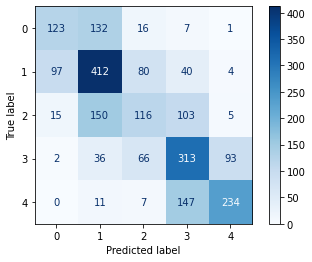

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_true = test_dataset[:]['labels']
cm = confusion_matrix(y_true, pred, labels = [0,1,2,3,4])
disp = ConfusionMatrixDisplay(cm,
                              display_labels=[0,1,2,3,4])
disp.plot(cmap="Blues", values_format='') 